In [ ]:
# script to plot all 12 tables of ignition delays

In [1]:
import os
import numpy as np
import pandas as pd
import cantera as ct


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the experimental conditions
ignition_delay_data = '/work/westgroup/harris.se/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == 7]
# Define Initial conditions using experimental data
tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
T7 = table7['T_C'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm


# list of starting conditions
# Mixture compositions taken from table 2 of
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
concentrations = []
# for phi = 1
x_diluent = 0.7649
conc_dict = {
    'O2(2)': 0.2038,
    'butane(1)': 0.03135
}

for i in range(0, len(table7)):
    x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
    x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
    x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
    conc_dict['N2'] = x_N2
    conc_dict['Ar'] = x_Ar
    conc_dict['CO2(7)'] = x_CO2
    concentrations.append(conc_dict)



In [3]:
# print(this_table)

In [4]:
# scale the delays to the nominal pressure
for i in range(1, 13):
    this_table = df_exp[df_exp['Table'] == i]
    nominal_pressure = this_table['nominal pressure(atm)'].values[0]
    actual_pressures = this_table['chamber pressure? (bar)'].values  # yes, confirmed units of bar here and atm there
    
    
    # get the concentrations
    concentrations = []
    # for phi = 1
    x_diluent = 0.7649
    conc_dict = {
        'O2(2)': 0.2038,
        'butane(1)': 0.03135
    }

    for i in range(0, len(table7)):
        x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
        x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
        x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
        conc_dict['N2'] = x_N2
        conc_dict['Ar'] = x_Ar
        conc_dict['CO2(7)'] = x_CO2
        concentrations.append(conc_dict)

    break
    # actual_pressure
    # print(this_table)



In [5]:
working_dir = '/work/westgroup/harris.se/autoscience/reaction_calculator/delay_uncertainty/'

In [6]:
Tmax = 1077  # use min and max temperature range of the data: 663K-1077K
Tmin = 663
N = 51
temperatures = np.linspace(Tmin, Tmax, N)


In [7]:
def get_table_phi(table_index):
    return df_exp[df_exp['Table'] == table_index]['phi'].values[0]

In [8]:
def get_table_pressure(table_index):
    return df_exp[df_exp['Table'] == table_index]['nominal pressure(atm)'].values[0]

In [34]:
# get_table_phi(7)

1.0

In [9]:
def scale_experimental_delay(original_delay, experimental_pressure, nominal_pressure, T):
    scale_factor = nominal_pressure / experimental_pressure
    if T < 1175:
        return original_delay * np.float_power(scale_factor, -0.34 - 0.70)
    else:
        return original_delay * np.float_power(scale_factor, 0.16 - 0.73)
        

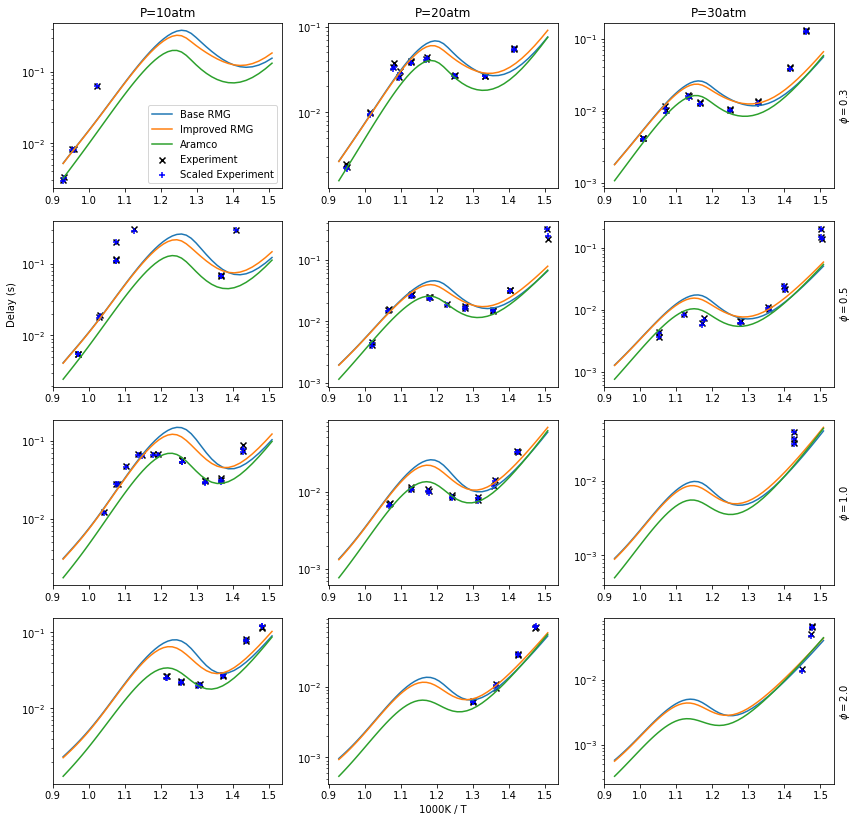

In [50]:
# read im the 12 datasets

# plt.figure(figsize=(12, 10))
fig, axes = plt.subplots(4, 3, figsize=(14, 14))

# plt.clf()
for i in range(1, 13):
    row = int((i - 1) / 3)
    col = (i - 1) % 3

    
    base_rmg_delay_npy = os.path.join(working_dir, 'base_rmg_1week', f'table_{i:04}', f'base_delays_{i:04}.npy')
    base_rmg_delay = np.load(base_rmg_delay_npy)

    improved_rmg_delay_npy = os.path.join(working_dir, 'improved_1week', f'table_{i:04}', f'base_delays_{i:04}.npy')
    improved_rmg_delay = np.load(improved_rmg_delay_npy)

    aramco_delay_npy = os.path.join(working_dir, 'aramco', f'table_{i:04}', f'base_delays_{i:04}.npy')
    aramco_delay = np.load(aramco_delay_npy)
    
    axes[row, col].plot(1000.0 / temperatures, base_rmg_delay, label='Base RMG')
    axes[row, col].plot(1000.0 / temperatures, improved_rmg_delay, label='Improved RMG')
    axes[row, col].plot(1000.0 / temperatures, aramco_delay, label='Aramco')
    
#     plt.subplot(0)
#     plt.plot(1000.0 / temperatures, base_rmg_delay, label='Base RMG')

    # Scale the experimental delay by the pressure
    
    experiment_temperatures = df_exp[df_exp['Table'] == i]['T_C'].values
    experiment_delays = df_exp[df_exp['Table'] == i]['time (ms)'].values / 1000.0
    experiment_pressures_atm = df_exp[df_exp['Table'] == i]['chamber pressure? (bar)'].values * 100000 / 101325  # convert to atm
    nominal_pressures_atm = df_exp[df_exp['Table'] == i]['nominal pressure(atm)'].values
    scaled_delays = np.zeros(len(experiment_delays))
    for j in range(len(experiment_temperatures)):
        scaled_delays[j] = scale_experimental_delay(experiment_delays[j], experiment_pressures_atm[j], nominal_pressures_atm[j], experiment_temperatures[j])
        
    
#     experiment_pressures = 
    
    axes[row, col].scatter(1000.0 / experiment_temperatures, experiment_delays, label='Experiment', marker='x', color='black')
    axes[row, col].scatter(1000.0 / experiment_temperatures, scaled_delays, label='Scaled Experiment', marker='+', color='blue')

    axes[row, col].set_yscale('log')
    

    
    
#     ax = plt.gca()
#     ax.set_yscale('log')
#     ax.set_ylim([0.00001, 0.1])
axes[1, 0].set_ylabel('Delay (s)')
axes[3, 1].set_xlabel('1000K / T')

axes[0, 0].set_title('P=10atm')
axes[0, 1].set_title('P=20atm')
axes[0, 2].set_title('P=30atm')

axes[0, 2].set_ylabel(r'$\phi=0.3$')
axes[0, 2].yaxis.set_label_position("right")
axes[1, 2].set_ylabel(r'$\phi=0.5$')
axes[1, 2].yaxis.set_label_position("right")
axes[2, 2].set_ylabel(r'$\phi=1.0$')
axes[2, 2].yaxis.set_label_position("right")
axes[3, 2].set_ylabel(r'$\phi=2.0$')
axes[3, 2].yaxis.set_label_position("right")

plt.sca(axes[0, 0])
plt.legend(loc='lower right')
#         plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))

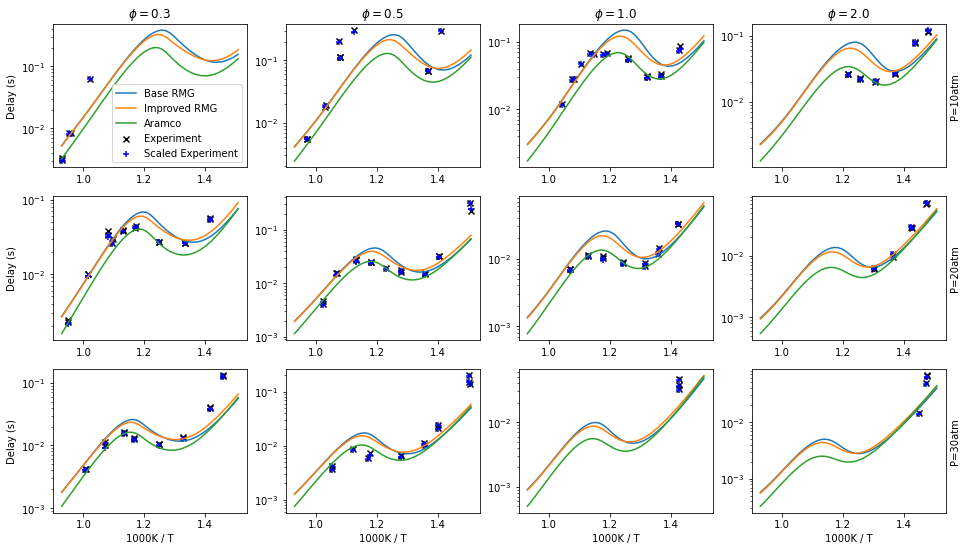

In [80]:
# same thing but horizontal
# read im the 12 datasets

# plt.figure(figsize=(12, 10))
fig, axes = plt.subplots(3, 4, figsize=(16, 9))

# plt.clf()
for i in range(1, 13):
    col = int((i - 1) / 3)
    row = (i - 1) % 3

    
    base_rmg_delay_npy = os.path.join(working_dir, 'base_rmg_1week', f'table_{i:04}', f'base_delays_{i:04}.npy')
    base_rmg_delay = np.load(base_rmg_delay_npy)

    improved_rmg_delay_npy = os.path.join(working_dir, 'improved_1week', f'table_{i:04}', f'base_delays_{i:04}.npy')
    improved_rmg_delay = np.load(improved_rmg_delay_npy)

    aramco_delay_npy = os.path.join(working_dir, 'aramco', f'table_{i:04}', f'base_delays_{i:04}.npy')
    aramco_delay = np.load(aramco_delay_npy)
    
    axes[row, col].plot(1000.0 / temperatures, base_rmg_delay, label='Base RMG')
    axes[row, col].plot(1000.0 / temperatures, improved_rmg_delay, label='Improved RMG')
    axes[row, col].plot(1000.0 / temperatures, aramco_delay, label='Aramco')
    
#     plt.subplot(0)
#     plt.plot(1000.0 / temperatures, base_rmg_delay, label='Base RMG')

    # Scale the experimental delay by the pressure
    
    experiment_temperatures = df_exp[df_exp['Table'] == i]['T_C'].values
    experiment_delays = df_exp[df_exp['Table'] == i]['time (ms)'].values / 1000.0
    experiment_pressures_atm = df_exp[df_exp['Table'] == i]['chamber pressure? (bar)'].values * 100000 / 101325  # convert to atm
    nominal_pressures_atm = df_exp[df_exp['Table'] == i]['nominal pressure(atm)'].values
    scaled_delays = np.zeros(len(experiment_delays))
    for j in range(len(experiment_temperatures)):
        scaled_delays[j] = scale_experimental_delay(experiment_delays[j], experiment_pressures_atm[j], nominal_pressures_atm[j], experiment_temperatures[j])
        
    
#     experiment_pressures = 
    
    axes[row, col].scatter(1000.0 / experiment_temperatures, experiment_delays, label='Experiment', marker='x', color='black')
    axes[row, col].scatter(1000.0 / experiment_temperatures, scaled_delays, label='Scaled Experiment', marker='+', color='blue')

    axes[row, col].set_yscale('log')
    

    
    
#     ax = plt.gca()
#     ax.set_yscale('log')
#     ax.set_ylim([0.00001, 0.1])
axes[0, 0].set_ylabel('Delay (s)')
axes[1, 0].set_ylabel('Delay (s)')
axes[2, 0].set_ylabel('Delay (s)')
axes[2, 0].set_xlabel('1000K / T')
axes[2, 1].set_xlabel('1000K / T')
axes[2, 2].set_xlabel('1000K / T')
axes[2, 3].set_xlabel('1000K / T')
# plt.sca(axes[2, 0])
# plt.text(2.0, 0.001, '1000K / T')  # this is in data coordinates

axes[0, 3].set_ylabel('P=10atm')
axes[1, 3].set_ylabel('P=20atm')
axes[2, 3].set_ylabel('P=30atm')
axes[0, 3].yaxis.set_label_position("right")
axes[1, 3].yaxis.set_label_position("right")
axes[2, 3].yaxis.set_label_position("right")


axes[0, 0].set_title(r'$\phi=0.3$')
axes[0, 1].set_title(r'$\phi=0.5$')
axes[0, 2].set_title(r'$\phi=1.0$')
axes[0, 3].set_title(r'$\phi=2.0$')


# axes[0, 2].set_ylabel(r'$\phi=0.3$')
# axes[0, 2].yaxis.set_label_position("right")
# axes[1, 2].set_ylabel(r'$\phi=0.5$')
# axes[1, 2].yaxis.set_label_position("right")
# axes[2, 2].set_ylabel(r'$\phi=1.0$')
# axes[2, 2].yaxis.set_label_position("right")
# axes[3, 2].set_ylabel(r'$\phi=2.0$')
# axes[3, 2].yaxis.set_label_position("right")

plt.sca(axes[0, 0])
plt.legend(loc='lower right')
#         plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))




## Just 2x3

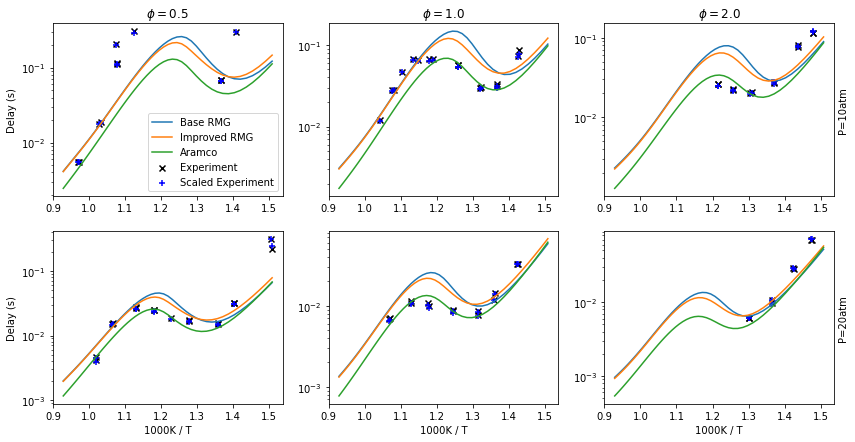

In [92]:
# Just 2,3
# same thing but horizontal
# read im the 12 datasets

# plt.figure(figsize=(12, 10))
fig, axes = plt.subplots(2, 3, figsize=(14, 7))

# plt.clf()
for i in range(1, 13):
    
    col = int((i - 1) / 3)
    row = (i - 1) % 3

    
    if col == 0:
        continue
    if row == 2:
        continue
        
    col -= 1
    
    base_rmg_delay_npy = os.path.join(working_dir, 'base_rmg_1week', f'table_{i:04}', f'base_delays_{i:04}.npy')
    base_rmg_delay = np.load(base_rmg_delay_npy)

    improved_rmg_delay_npy = os.path.join(working_dir, 'improved_1week', f'table_{i:04}', f'base_delays_{i:04}.npy')
    improved_rmg_delay = np.load(improved_rmg_delay_npy)

    aramco_delay_npy = os.path.join(working_dir, 'aramco', f'table_{i:04}', f'base_delays_{i:04}.npy')
    aramco_delay = np.load(aramco_delay_npy)
    
    axes[row, col].plot(1000.0 / temperatures, base_rmg_delay, label='Base RMG')
    axes[row, col].plot(1000.0 / temperatures, improved_rmg_delay, label='Improved RMG')
    axes[row, col].plot(1000.0 / temperatures, aramco_delay, label='Aramco')


    # Scale the experimental delay by the pressure
    
    experiment_temperatures = df_exp[df_exp['Table'] == i]['T_C'].values
    experiment_delays = df_exp[df_exp['Table'] == i]['time (ms)'].values / 1000.0
    experiment_pressures_atm = df_exp[df_exp['Table'] == i]['chamber pressure? (bar)'].values * 100000 / 101325  # convert to atm
    nominal_pressures_atm = df_exp[df_exp['Table'] == i]['nominal pressure(atm)'].values
    scaled_delays = np.zeros(len(experiment_delays))
    for j in range(len(experiment_temperatures)):
        scaled_delays[j] = scale_experimental_delay(experiment_delays[j], experiment_pressures_atm[j], nominal_pressures_atm[j], experiment_temperatures[j])
        
    
    axes[row, col].scatter(1000.0 / experiment_temperatures, experiment_delays, label='Experiment', marker='x', color='black')
    axes[row, col].scatter(1000.0 / experiment_temperatures, scaled_delays, label='Scaled Experiment', marker='+', color='blue')

    axes[row, col].set_yscale('log')
    
axes[0, 0].set_ylabel('Delay (s)')
axes[1, 0].set_ylabel('Delay (s)')
axes[1, 0].set_xlabel('1000K / T')
axes[1, 1].set_xlabel('1000K / T')
axes[1, 2].set_xlabel('1000K / T')

axes[0, 2].set_ylabel('P=10atm')
axes[1, 2].set_ylabel('P=20atm')
axes[0, 2].yaxis.set_label_position("right")
axes[1, 2].yaxis.set_label_position("right")


axes[0, 0].set_title(r'$\phi=0.5$')
axes[0, 1].set_title(r'$\phi=1.0$')
axes[0, 2].set_title(r'$\phi=2.0$')


plt.sca(axes[0, 0])
plt.legend(loc='lower right')




In [ ]:
delay3 = np.load(os.path.join(working_dir, 'base_rmg_1week', f'table_0002', f'base_delays_0002.npy'))
delay6 = np.load(os.path.join(working_dir, 'base_rmg_1week', f'table_0005', f'base_delays_0005.npy'))

In [ ]:
delay6 - delay3

In [ ]:
axes[3]

In [ ]:


for i in [9]:
    # read in the three datasets
    base_rmg_delay_data = os.path.join(working_dir, 'base_rmg', f'table_{i}_smooth.csv')
    improved_rmg_delay_data = os.path.join(working_dir, 'improved_rmg', f'table_{i}_smooth.csv')
    aramco_delay_data = os.path.join(working_dir, 'aramco', f'table_{i}_smooth.csv')
    
    base_rmg_df = pd.read_csv(base_rmg_delay_data)
    if 'Unnamed: 0' in base_rmg_df.keys():  
        base_rmg_df = base_rmg_df.drop(columns=['Unnamed: 0'])
    improved_rmg_delay_data = pd.read_csv(improved_rmg_delay_data)
    if 'Unnamed: 0' in improved_rmg_delay_data.keys():  
        improved_rmg_delay_data = improved_rmg_delay_data.drop(columns=['Unnamed: 0'])
    aramco_delay_data = pd.read_csv(aramco_delay_data)
    if 'Unnamed: 0' in base_rmg_df.keys():  
        aramco_delay_data = aramco_delay_data.drop(columns=['Unnamed: 0'])
    
#     print(base_rmg_df['T'].values), len(improved_rmg_df['T'].values), len(aramco_df['T'].values))

In [ ]:
base_rmg_df['T'].values

In [ ]:


for i in range(1, 13):
    plt.clf()
    # read in the three datasets
    base_rmg_delay_data = os.path.join(working_dir, 'base_rmg', f'table_{i}_smooth.csv')
    improved_rmg_delay_data = os.path.join(working_dir, 'improved_rmg', f'table_{i}_smooth.csv')
    aramco_delay_data = os.path.join(working_dir, 'aramco', f'table_{i}_smooth.csv')
    
    base_rmg_df = pd.read_csv(base_rmg_delay_data)
    if 'Unnamed: 0' in base_rmg_df.keys():  
        base_rmg_df = base_rmg_df.drop(columns=['Unnamed: 0'])
    improved_rmg_df = pd.read_csv(improved_rmg_delay_data)
    if 'Unnamed: 0' in improved_rmg_df.keys():  
        improved_rmg_df = improved_rmg_df.drop(columns=['Unnamed: 0'])
    aramco_df = pd.read_csv(aramco_delay_data)
    if 'Unnamed: 0' in aramco_df.keys():  
        aramco_df = aramco_df.drop(columns=['Unnamed: 0'])

        
    # get the experimental data    
    exp_table = df_exp[df_exp['Table'] == i]
    
    # plot the ignition delay
    N = 51
    if i == 9:
        plt.scatter(1000.0 / base_rmg_df['T'].values, base_rmg_df['delay(ms)'].values)
        plt.scatter(1000.0 / improved_rmg_df['T'].values[N:2 * N], improved_rmg_df['delay(ms)'].values[N:2 * N])
        plt.scatter(1000.0 / aramco_df['T'].values[2 * N:3 * N], aramco_df['delay(ms)'].values[2 * N:3 * N])
    else:
    
        plt.plot(1000.0 / base_rmg_df['T'].values, base_rmg_df['delay(ms)'].values)
        plt.plot(1000.0 / improved_rmg_df['T'].values[N:2 * N], improved_rmg_df['delay(ms)'].values[N:2 * N])
        plt.plot(1000.0 / aramco_df['T'].values[2 * N:3 * N], aramco_df['delay(ms)'].values[2 * N:3 * N])
#     plt.plot(1000.0 / T7, base_rmg7, marker='x', linestyle='dashed')
#     plt.plot(1000.0 / T7, aramco7, marker='x')
    plt.scatter(1000.0 / exp_table['T_C'].values, exp_table['time (ms)'].values.astype(float) / 1000.0, color='black', marker='x')
    ax = plt.gca()
    ax.set_yscale('log')
    
    plt.legend(['Base RMG', 'Improved RMG', 'Aramco', 'Experiment'])
    plt.title('Ignition Delays $\phi$=' + str(base_rmg_df['phi'].values[0]))
    plt.xlabel('1000K / T')
    plt.ylabel('Delay (s)')
    plt.savefig(f'table_{i}.png')

#     print(base_rmg_df)

In [ ]:
len(1000.0 / aramco_delay_data['T'].values)

In [ ]:
plt.plot(1000.0 / base_rmg_df['T'].values[:])

In [ ]:
base_rmg_df['delay(ms)'].values[:]

In [ ]:
# plot the ignition delay
plt.plot(1000.0 / T7, delays, marker='x')
plt.plot(1000.0 / T7, base_rmg7, marker='x', linestyle='dashed')
plt.plot(1000.0 / T7, aramco7, marker='x')
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black')
ax = plt.gca()
ax.set_yscale('log')
plt.legend(['New Calculations', 'Base RMG', 'Aramco', 'Experiment'])
plt.title('Ignition Delays $\phi$=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table7.png')
